<a href="https://colab.research.google.com/github/Abhyu001/ECG-GAN-Generative-Adversarial-Network-for-ECG-Signal-Synthesis/blob/main/GAN_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
import tarfile
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.sequence import pad_sequences
import math
import warnings
import os
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy import signal
from tqdm import tqdm

2024-10-29 06:17:13.682487: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 06:17:13.682614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 06:17:13.819725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def load_challenge_data(filename):
    """Load ECG files"""
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [ ]:
def downsample_ecg(ecg, samples=1000, leads=12):
    """Function used to downsample ECGs from 500Hz to 100Hz"""
    new_ecg = np.zeros((samples,leads))
    for i,j in enumerate(ecg):
        new_ecg[:,i] = signal.resample(j,samples)
    return new_ecg

In [ ]:
# Import ECGs to RAM
print("Importing real ECGs..")
ECGs = []
for ecgfilename in tqdm(sorted(os.listdir("/kaggle/input/ptbxl-electrocardiography-database/WFDB/"))):
    if ecgfilename.endswith(".mat"):
        data = load_challenge_data("/kaggle/input/ptbxl-electrocardiography-database/WFDB/" + ecgfilename)[0]
        ECGs.append(downsample_ecg(data))
ECGs = np.asarray(ECGs)

# Convert ECG unit from microvolt to millivolt
ECGs= ECGs/1000

print("A total of {} ECGs were loaded".format(len(ECGs)))

Importing real ECGs..


100%|██████████| 43674/43674 [06:26<00:00, 113.13it/s]


A total of 21837 ECGs were loaded


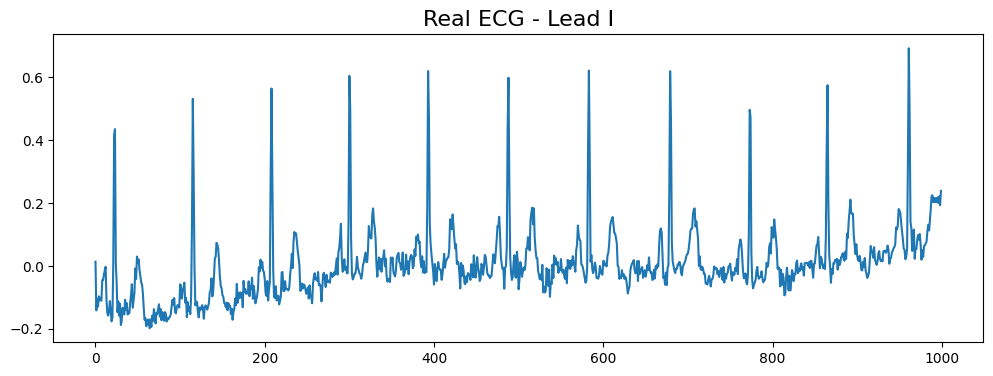

In [ ]:
plt.figure(figsize=(12,4))
plt.title("Real ECG - Lead I", fontsize=16)
plt.plot(ECGs[0,:,0])
plt.show()


In [ ]:
# generate n real samples with class labels
def generate_real_samples(ecgsignal,n):
    """Randomly pick n real ECG samples from the dataset and return it together with an array of n ones """
    # generate inputs in [-0.5, 0.5]
    X = ecgsignal[np.random.choice(ecgsignal.shape[0],n)]
    # generate class labels
    y = tf.ones((n, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    """Generate random numbers used as input to the generator """
    # generate points in the latent space
    x_in = np.random.randn(latent_dim*n).reshape(n,latent_dim)
    # reshape into a batch of inputs for the network
    return np.expand_dims(x_in,1)

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(latent_dim,generator,n):
    """Use the generator to generate fake ECGs"""
    # generate points in latent space
    x_input = generate_latent_points(latent_dim,n)
    # predict outputs
    X = generator(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

def compare_real_and_gen_ecg(generated_ecg,lead = 0):
    """Plot real and generated ECGs side by side"""
    plt.figure(figsize=(24,4))
    plt.subplot(1,2,1)
    plt.title(f"Generated (fake) ECG - Lead {lead+1}", fontsize=16)
    plt.plot(generated_ecg[0,:,lead])
    plt.subplot(1,2,2)
    plt.title(f"Real ECG - Lead {lead+1}", fontsize=16)
    rand_idx = np.random.choice(np.arange(len(ECGs)))
    plt.plot(ECGs[rand_idx,:,lead])
    plt.show()

In [ ]:



def _custom_inception_module(
    input_tensor,
    stride=1,
    activation_function="relu",  # Updated parameter name for clarity
    apply_bottleneck=True,
    kernel_dim=40,  # Updated parameter name
    bottleneck_filters=64,  # Updated parameter name
    conv_filters=64,  # Updated parameter name
):
    """
    Custom Inception module implementation for 1D input.
    """
    if apply_bottleneck and int(input_tensor.shape[-1]) > 1:
        # Bottleneck layer for dimensionality reduction
        inception_input = tf.keras.layers.Conv1D(
            filters=bottleneck_filters,
            kernel_size=1,
            padding="same",
            activation=activation_function,
            use_bias=False,
        )(input_tensor)
    else:
        inception_input = input_tensor

    # Define varying kernel sizes
    kernel_sizes = [kernel_dim // (2 ** i) for i in range(4)]  # Added flexibility for 4 kernels

    conv_layers = []
    for i, kernel in enumerate(kernel_sizes):
        conv_layers.append(
            tf.keras.layers.Conv1D(
                filters=conv_filters,
                kernel_size=kernel,
                strides=stride,
                padding="same",
                activation=activation_function,
                use_bias=False,
            )(inception_input)
        )

    # Max pooling branch
    max_pool = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding="same")(input_tensor)
    max_pool_conv = tf.keras.layers.Conv1D(
        filters=conv_filters,
        kernel_size=1,
        padding="same",
        activation=activation_function,
        use_bias=False,
    )(max_pool)

    # Add max_pool_conv to the convolutional layers list
    conv_layers.append(max_pool_conv)

    # Concatenate convolution results
    concatenated_output = tf.keras.layers.Concatenate(axis=2)(conv_layers)
    normalized_output = tf.keras.layers.BatchNormalization()(concatenated_output)
    output = tf.keras.layers.Activation(activation=activation_function)(normalized_output)

    return output


def _residual_shortcut_layer(input_tensor, output_tensor):
    """
    Creates a shortcut connection between input and output layers, enabling residual learning.
    """
    residual = tf.keras.layers.Conv1D(
        filters=int(output_tensor.shape[-1]),
        kernel_size=1,
        padding="same",
        use_bias=False,
    )(input_tensor)
    residual = tf.keras.layers.BatchNormalization()(residual)

    added_output = tf.keras.layers.Add()([residual, output_tensor])
    final_output = tf.keras.layers.Activation("relu")(added_output)

    return final_output


def discriminator_model(
    input_shape=(1000, 12),
    output_classes=1,
    inception_depth=2,  # Updated parameter name
    residual_enabled=True,  # Updated parameter name
) -> tf.keras.models.Model:
    """
    Custom Discriminator model for binary classification.
    Architecture inspired by 'InceptionTime'.
    """
    input_layer = tf.keras.layers.Input(input_shape)
    x = input_layer
    residual_input = input_layer

    for layer_depth in range(inception_depth):
        x = _custom_inception_module(x)

        if residual_enabled and layer_depth % 2 == 1:
            x = _residual_shortcut_layer(residual_input, x)
            residual_input = x

    # Global Average Pooling layer
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Output Layer
    output_layer = tf.keras.layers.Dense(units=output_classes, activation="sigmoid")(global_avg_pooling)

    # Model definition
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        metrics=[tf.keras.metrics.BinaryAccuracy()],
    )

    return model


discriminator = discriminator_model()
print("Discriminator architecture:")
print(discriminator.summary())

discriminator.load_weights("/kaggle/input/weights-with-relu/descriminator_weights_with_ReLU.weights.h5")


def generator_model():
    """
    Custom Generator model using Conv1DTranspose layers.
    """
    model = tf.keras.Sequential()

    # Dense layer with increased units for reshaping
    model.add(tf.keras.layers.Dense(256 * 1000, use_bias=False, input_shape=(1, 12)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Reshape((1000, 256)))
    assert model.output_shape == (None, 1000, 256)  # Ensure correct reshaping

    # Transpose Convolution Layers
    model.add(tf.keras.layers.Conv1DTranspose(128, 5, strides=1, padding="same", use_bias=False))
    assert model.output_shape == (None, 1000, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv1DTranspose(64, 5, strides=1, padding="same", use_bias=False))
    assert model.output_shape == (None, 1000, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    # Output layer with 'tanh' activation
    model.add(tf.keras.layers.Conv1DTranspose(12, 5, strides=1, padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 1000, 12)

    return model


generator = generator_model()
print("Generator architecture:")
print(generator.summary())

generator.load_weights("/kaggle/input/weights-with-relu/generator_weights_with_ReLU.weights.h5")


Discriminator architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1000, 64)  │        768 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1000, 12)  │          0 │ input_layer[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1000, 64)  │    163,840 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1000, 64)  │     81,920 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1000, 64)  │     40,960 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1000, 64)  │     20,480 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1000, 64)  │        768 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1000, 320) │          0 │ conv1d_1[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1000, 320) │      1,280 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1000, 320) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1000, 64)  │     20,480 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1000, 320) │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1000, 64)  │    163,840 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1000, 64)  │     81,920 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1000, 64)  │     40,960 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 1000, 64)  │     20,480 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1000, 64)  │     20,480 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1000, 320) │          0 │ conv1d_7[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_8[0][0],   │
│                     │                   │            │ conv1d_9[0][0],   │
│                     │                   │            │ conv1d_10[0][0],

 Total params: 664,897 (2.54 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 1,920 (7.50 KB)

None
Generator architecture:


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1, 256000)      │     3,072,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 256000)      │     1,024,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1, 256000)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1000, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 1000, 128)      │       163,840 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 1000, 64)       │        40,960 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 1000, 12)       │         3,840 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,305,408 (16.42 MB)

 Trainable params: 3,793,024 (14.47 MB)

 Non-trainable params: 512,384 (1.95 MB)

None


In [ ]:
# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
else:
    print("No GPUs available.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Before training:


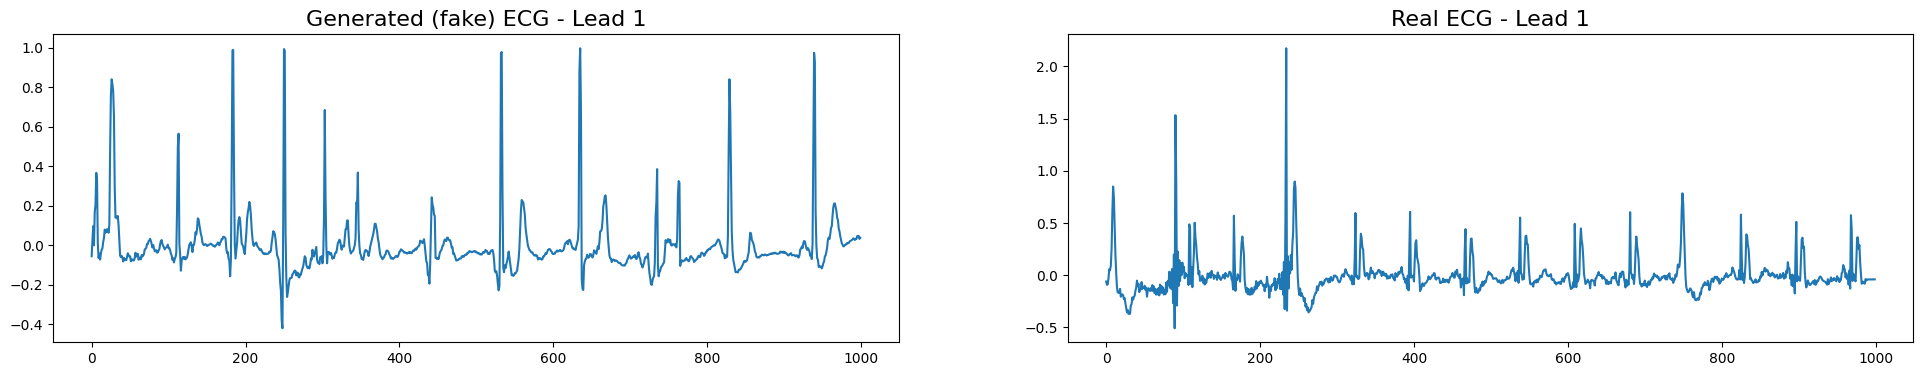

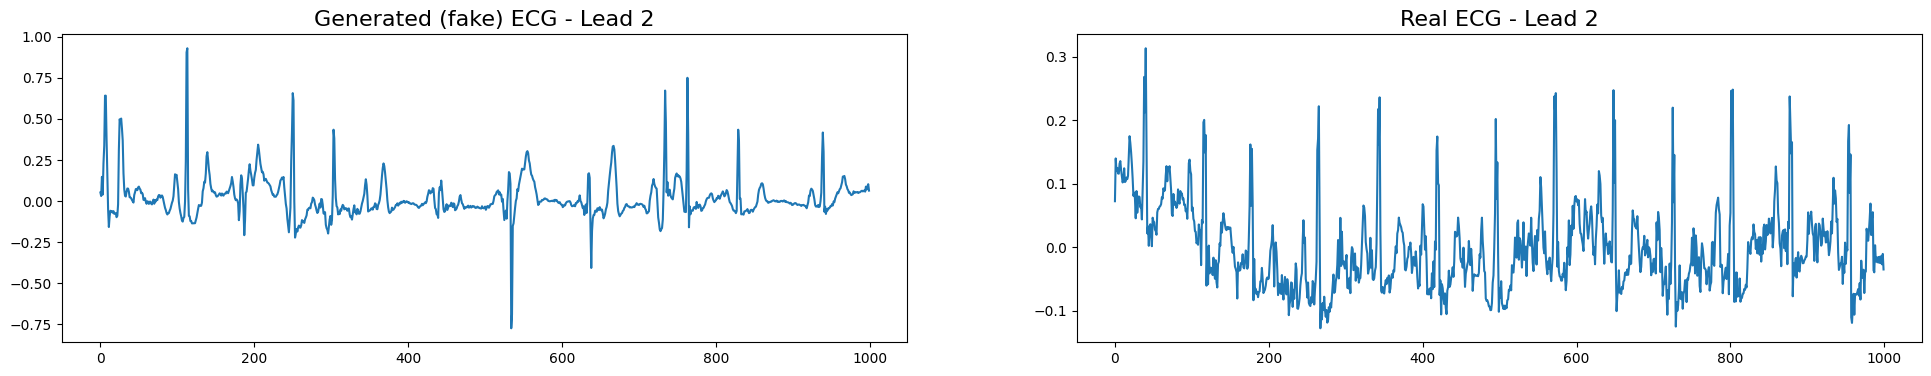

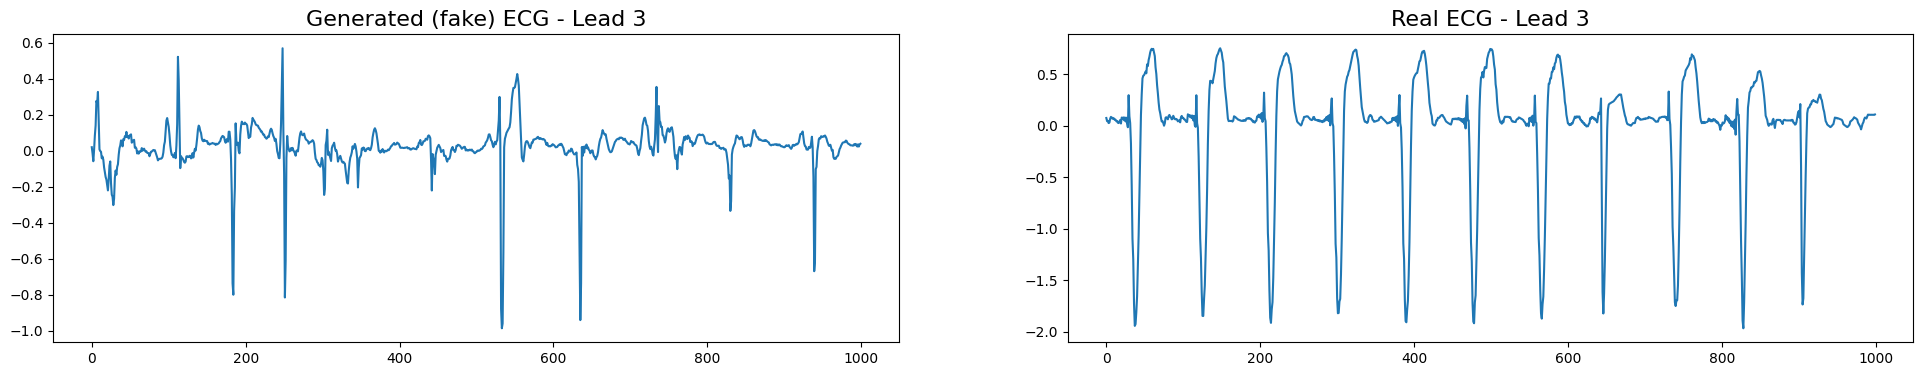

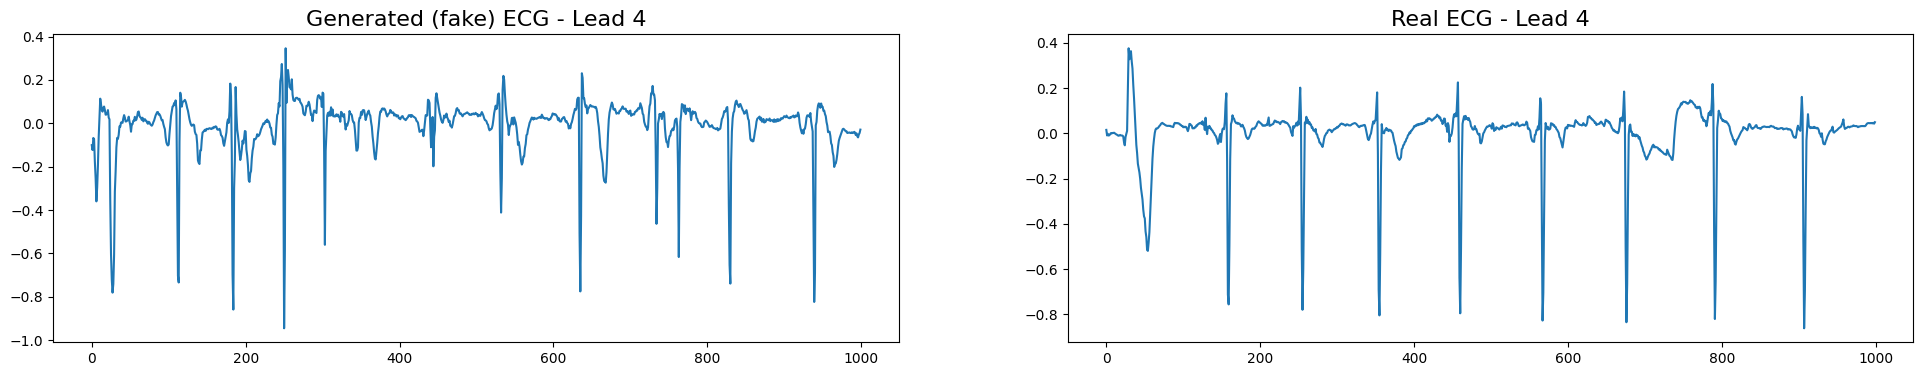

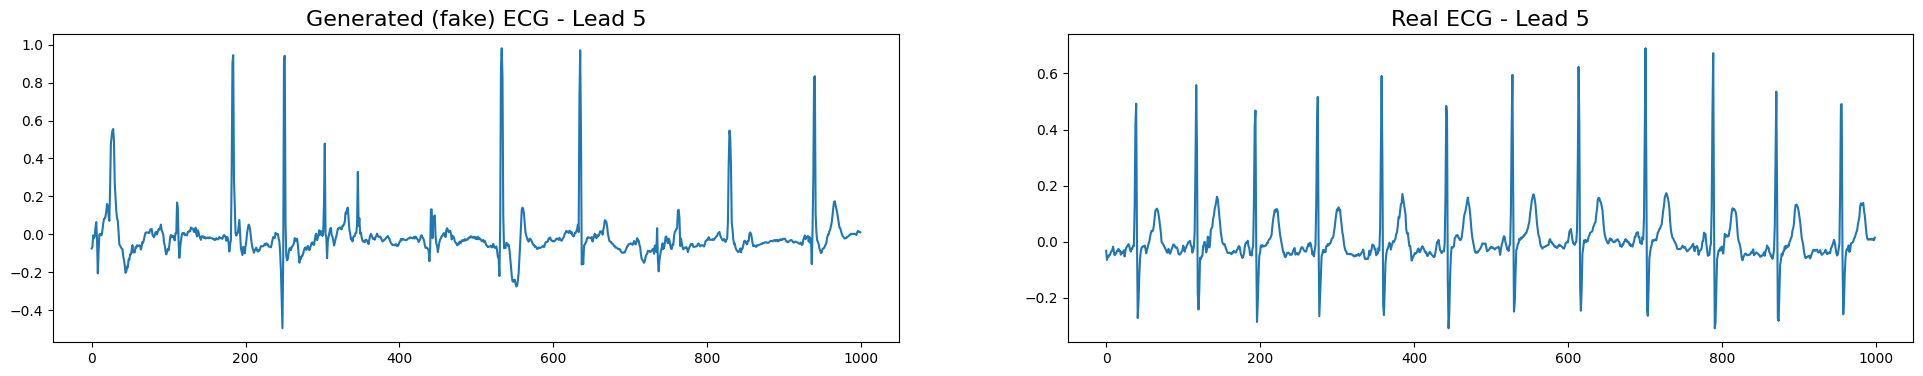

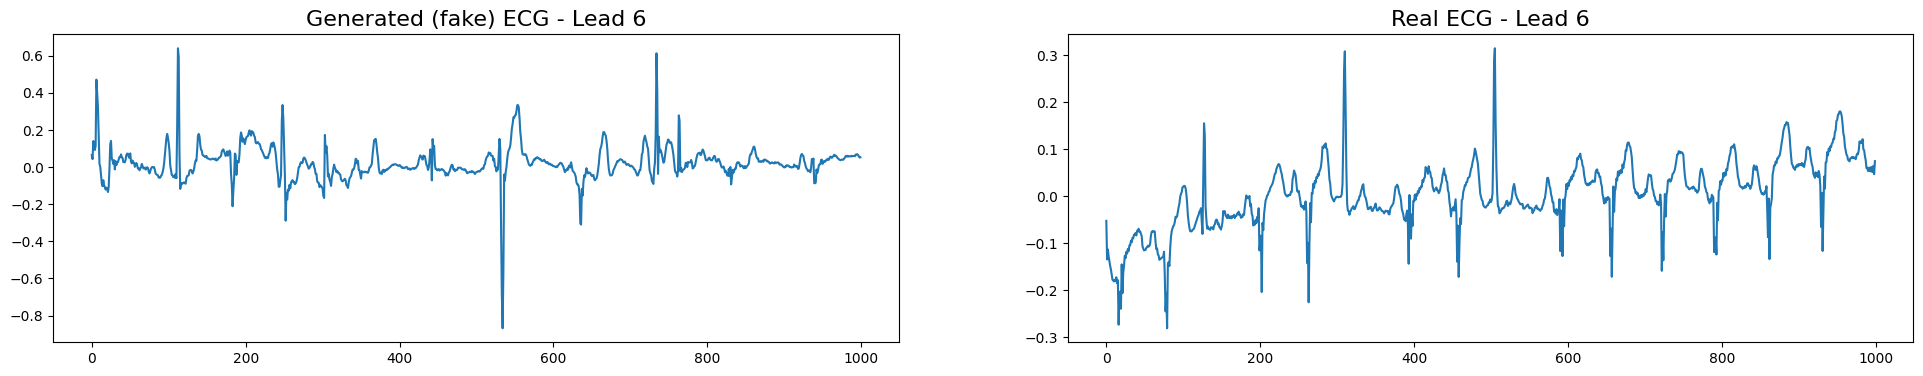

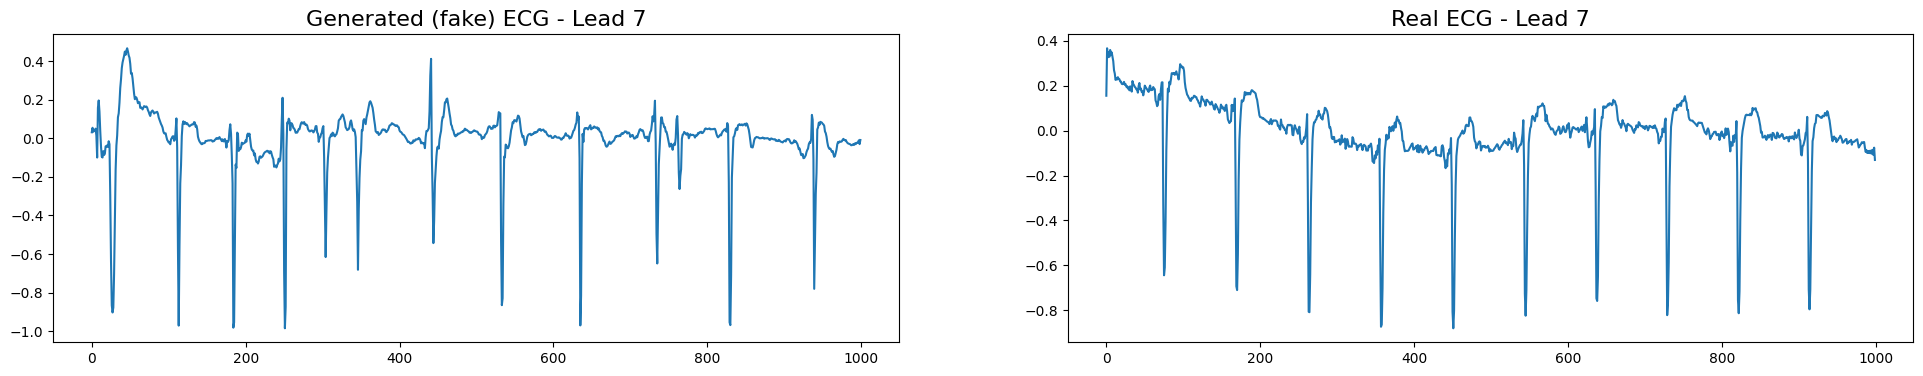

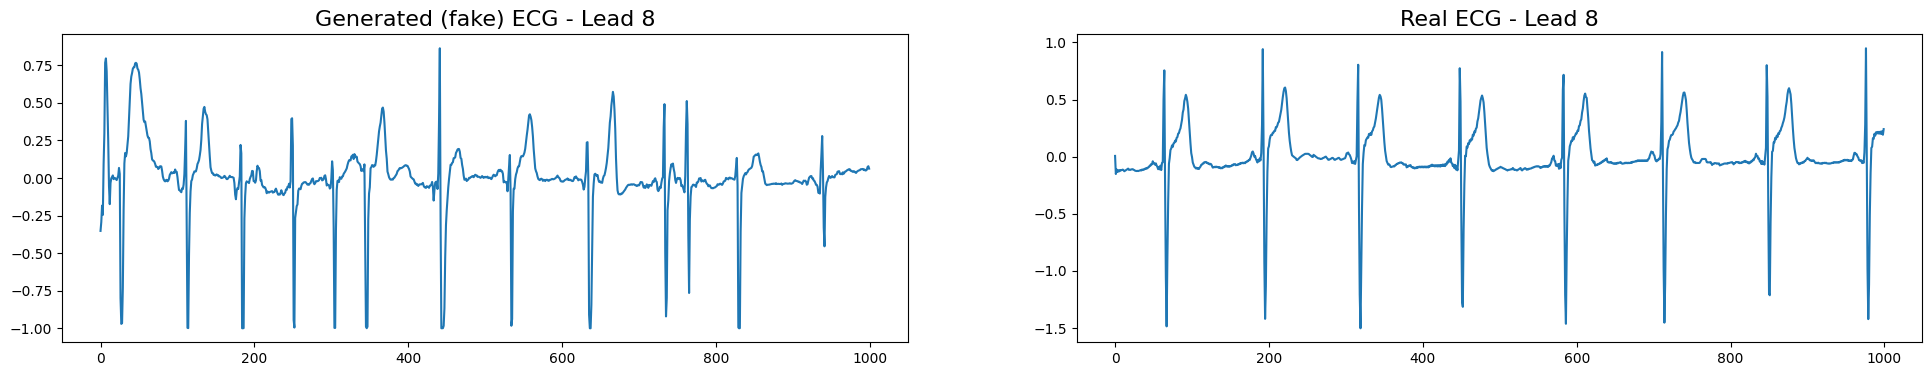

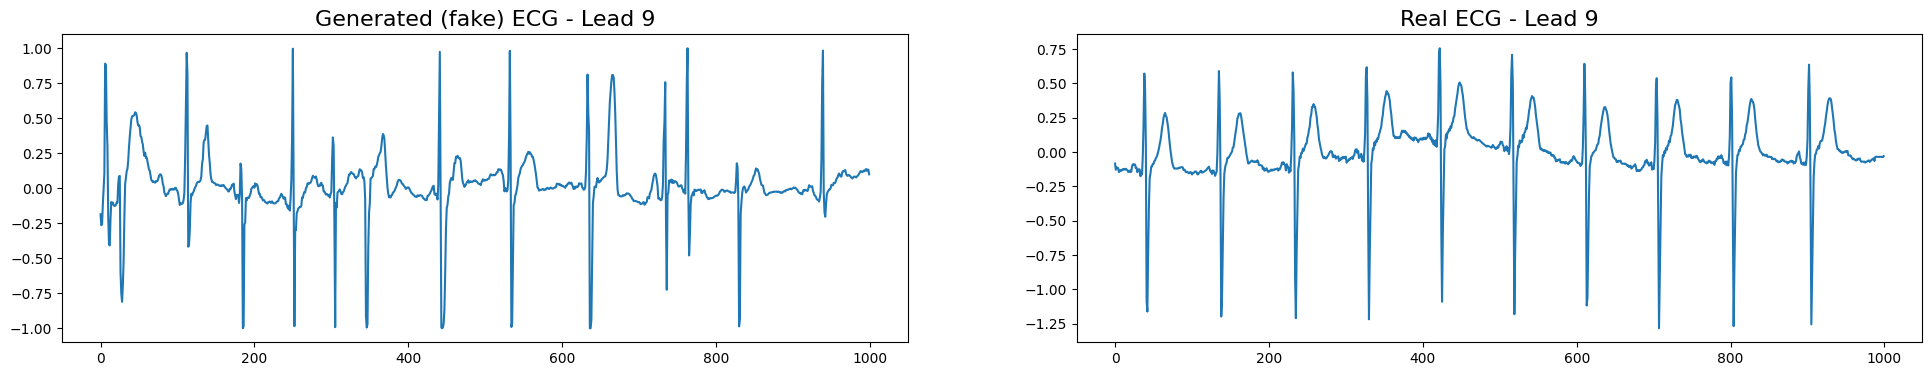

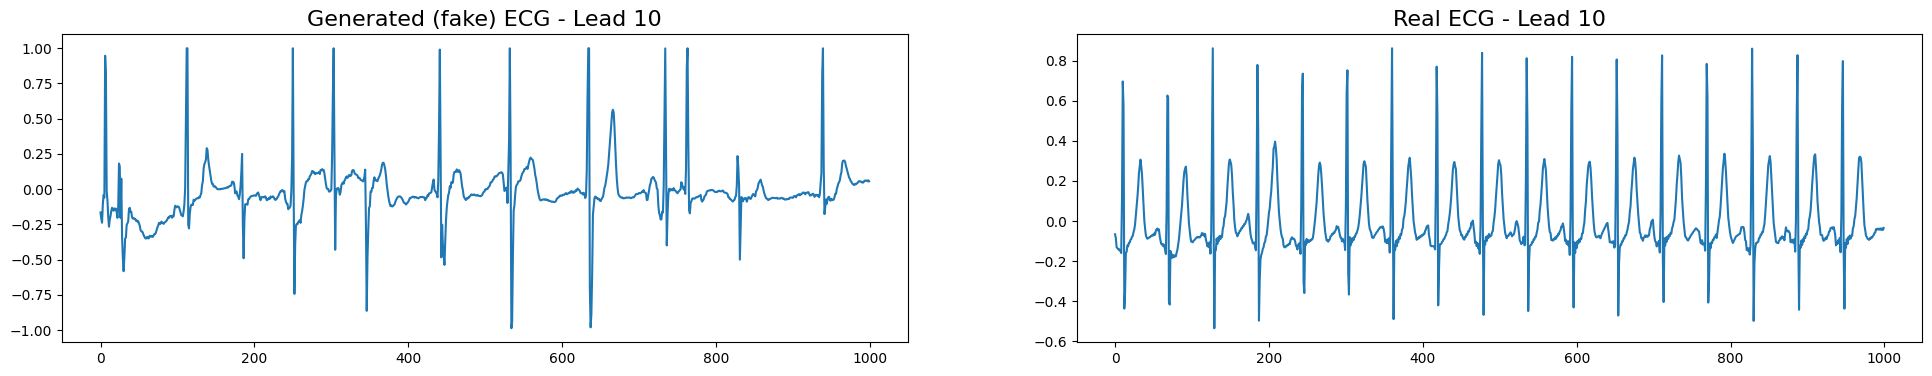

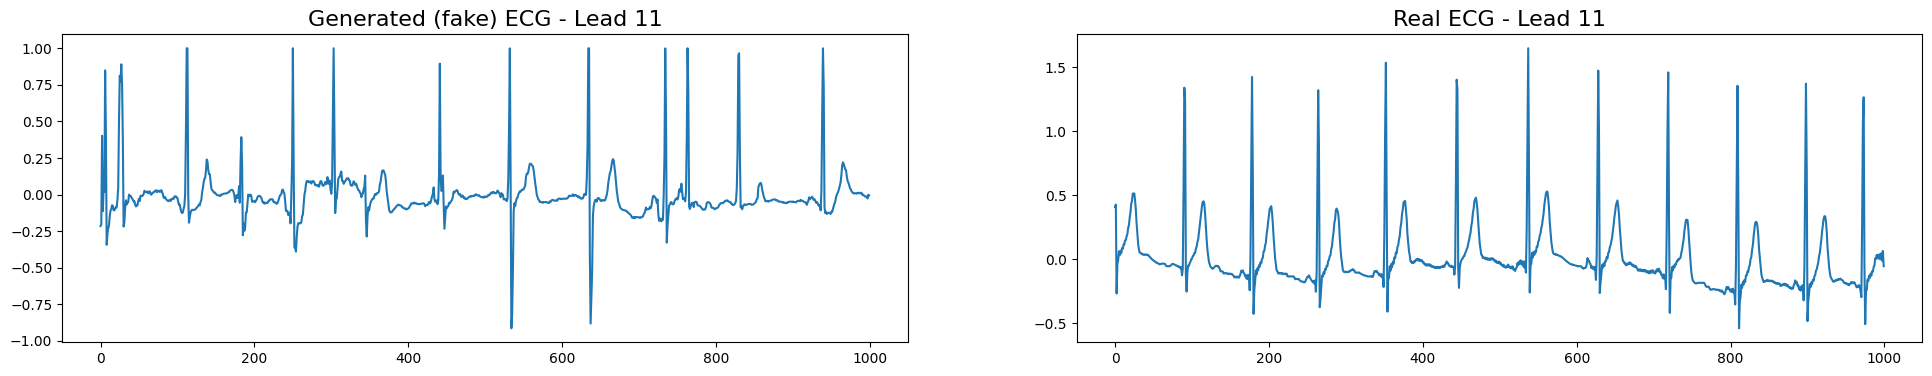

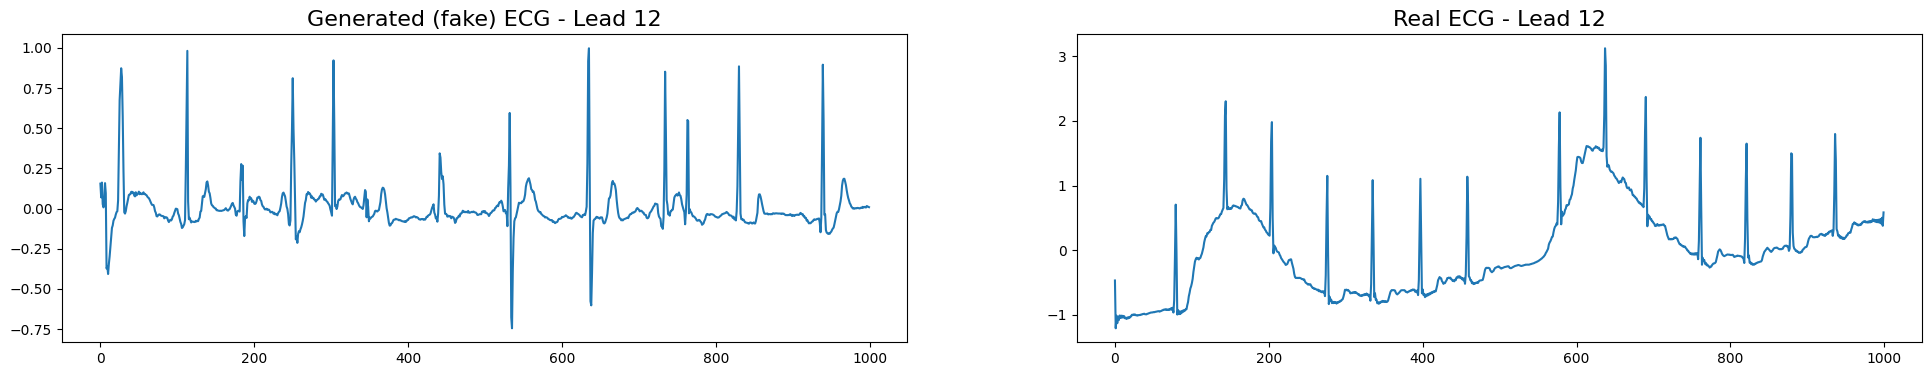

-------------------


In [ ]:
batch_size = 128
latent_dim = 12
steps = len(ECGs) // batch_size
half_batch = batch_size // 2
epochs = 50
init_lr_desc = 0.00002
init_lr_gen = 0.00004

opt_gen = tf.keras.optimizers.RMSprop(learning_rate=0.00005,rho =0.9)
opt_desc = tf.keras.optimizers.RMSprop(learning_rate=0.00005,rho =0.9)

# Lists to store losses
loss_gan_history = []
loss_desc_history = []

print("Before training:")
latent_points = generate_latent_points(latent_dim, 1)
res = generator(latent_points)
for lead in range(0,12):
    compare_real_and_gen_ecg(res,lead)
print("-------------------")


Epoch 1/20
Time for epoch 1: 6.29 seconds


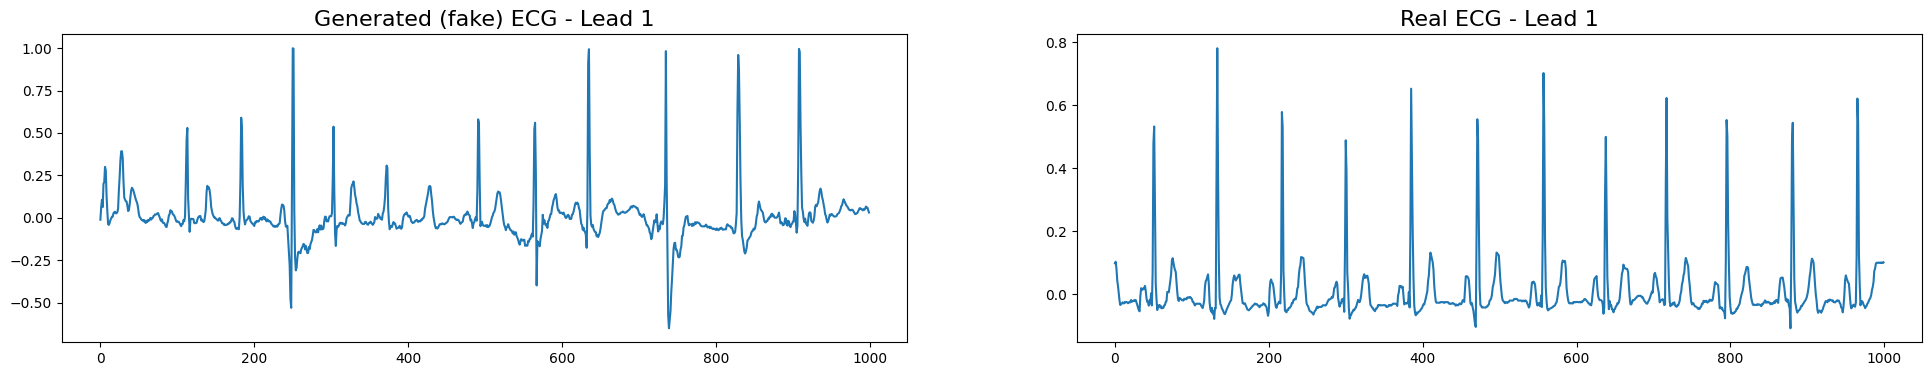

Generator AUROC: nan
Generator loss: 1.2083
Discriminator AUROC: 0.8245
Discriminator loss: 0.4480
-------------------
Epoch 2/20
Time for epoch 2: 3.22 seconds
Generator AUROC: nan
Generator loss: 1.3011
Discriminator AUROC: 0.8899
Discriminator loss: 0.3800
-------------------
Epoch 3/20
Time for epoch 3: 3.22 seconds
Generator AUROC: nan
Generator loss: 1.2969
Discriminator AUROC: 0.9124
Discriminator loss: 0.4152
-------------------
Epoch 4/20
Time for epoch 4: 3.23 seconds
Generator AUROC: nan
Generator loss: 1.2906
Discriminator AUROC: 0.7344
Discriminator loss: 0.3939
-------------------
Epoch 5/20
Time for epoch 5: 3.23 seconds
Generator AUROC: nan
Generator loss: 1.3066
Discriminator AUROC: 0.8901
Discriminator loss: 0.3943
-------------------
Epoch 6/20
Time for epoch 6: 3.25 seconds


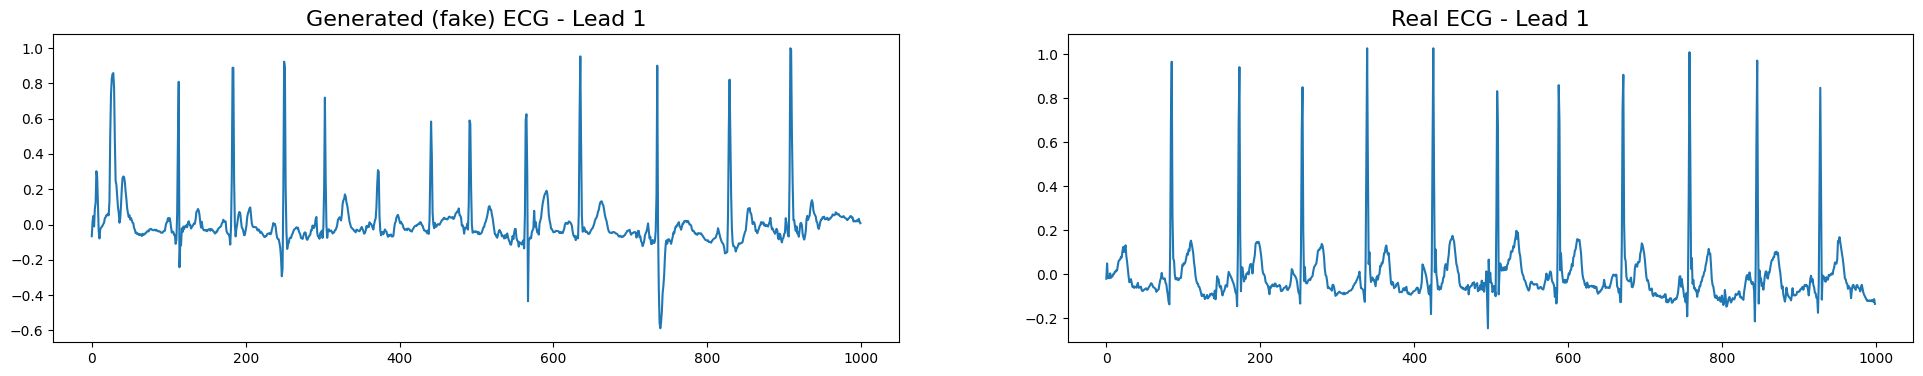

Generator AUROC: nan
Generator loss: 1.3044
Discriminator AUROC: 0.7520
Discriminator loss: 0.4115
-------------------
Epoch 7/20
Time for epoch 7: 3.24 seconds
Generator AUROC: nan
Generator loss: 1.2854
Discriminator AUROC: 0.7463
Discriminator loss: 0.3961
-------------------
Epoch 8/20
Time for epoch 8: 3.26 seconds
Generator AUROC: nan
Generator loss: 1.2897
Discriminator AUROC: 0.8936
Discriminator loss: 0.3826
-------------------
Epoch 9/20
Time for epoch 9: 3.25 seconds
Generator AUROC: nan
Generator loss: 1.2782
Discriminator AUROC: 0.8364
Discriminator loss: 0.3888
-------------------
Epoch 10/20
Time for epoch 10: 3.24 seconds
Generator AUROC: nan
Generator loss: 1.3175
Discriminator AUROC: 0.7634
Discriminator loss: 0.3870
-------------------
Epoch 11/20
Time for epoch 11: 3.24 seconds


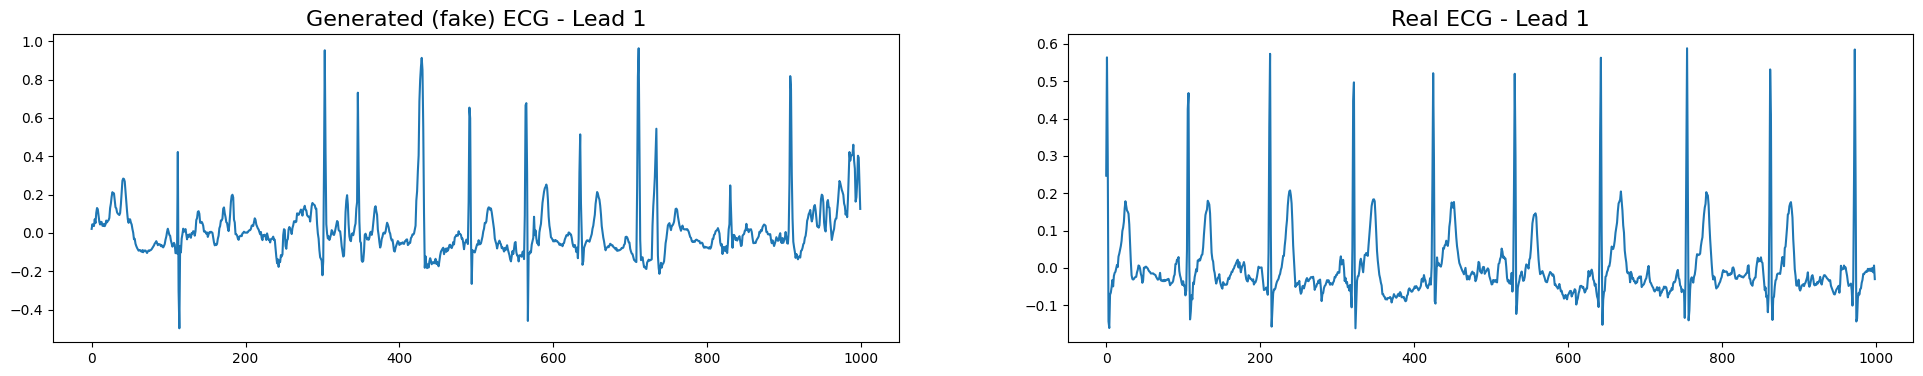

Generator AUROC: nan
Generator loss: 1.3072
Discriminator AUROC: 0.8079
Discriminator loss: 0.3911
-------------------
Epoch 12/20
Time for epoch 12: 3.25 seconds
Generator AUROC: nan
Generator loss: 1.2794
Discriminator AUROC: 0.8601
Discriminator loss: 0.3940
-------------------
Epoch 13/20
Time for epoch 13: 3.24 seconds
Generator AUROC: nan
Generator loss: 1.3086
Discriminator AUROC: 0.8140
Discriminator loss: 0.3850
-------------------
Epoch 14/20
Time for epoch 14: 3.25 seconds
Generator AUROC: nan
Generator loss: 1.2927
Discriminator AUROC: 0.8770
Discriminator loss: 0.3732
-------------------
Epoch 15/20
Time for epoch 15: 3.25 seconds
Generator AUROC: nan
Generator loss: 1.2991
Discriminator AUROC: 0.7227
Discriminator loss: 0.3900
-------------------
Epoch 16/20
Time for epoch 16: 3.23 seconds


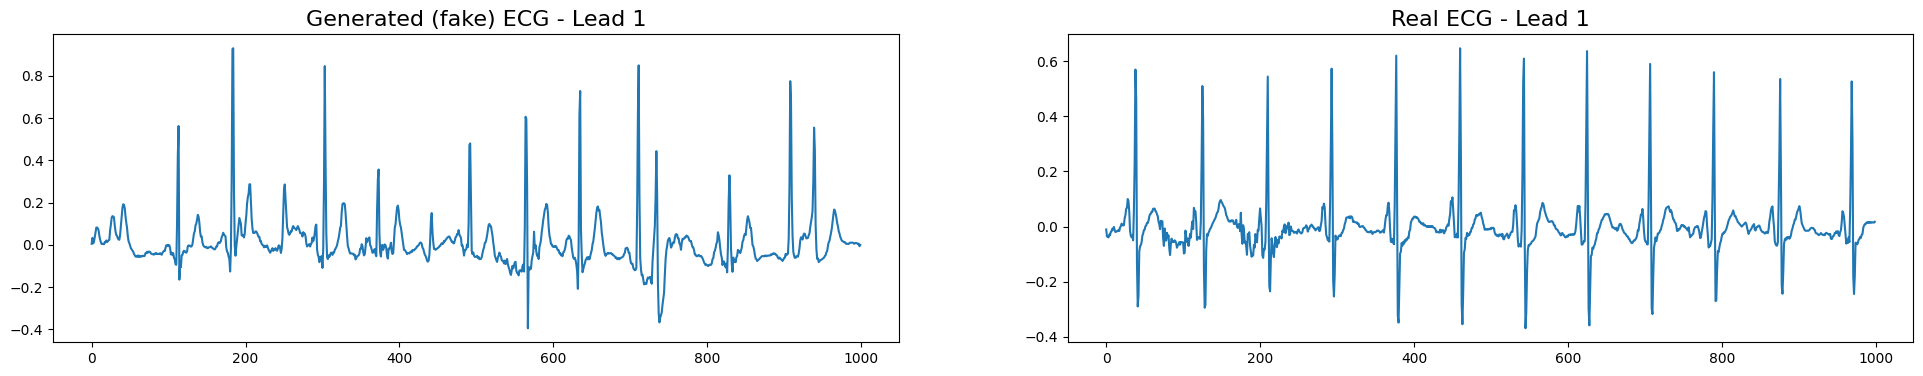

Generator AUROC: nan
Generator loss: 1.2696
Discriminator AUROC: 0.9167
Discriminator loss: 0.4017
-------------------
Epoch 17/20
Time for epoch 17: 3.24 seconds
Generator AUROC: nan
Generator loss: 1.2997
Discriminator AUROC: 0.8623
Discriminator loss: 0.3590
-------------------
Epoch 18/20
Time for epoch 18: 3.23 seconds
Generator AUROC: nan
Generator loss: 1.2851
Discriminator AUROC: 0.7893
Discriminator loss: 0.4113
-------------------
Epoch 19/20
Time for epoch 19: 3.24 seconds
Generator AUROC: nan
Generator loss: 1.3234
Discriminator AUROC: 0.8926
Discriminator loss: 0.3576
-------------------
Epoch 20/20
Time for epoch 20: 3.24 seconds
Generator AUROC: nan
Generator loss: 1.3077
Discriminator AUROC: 0.8967
Discriminator loss: 0.3866
-------------------


In [ ]:
import time
# Training loop
epochs=20
steps=10
gen= generator
desc=discriminator
for epoch in range(epochs):
    start_time = time.time()  # Record the start time

    # Adjust learning rate every 5 epochs
    if epoch % 5 == 0 and epoch > 0:
        init_lr_desc /= 2
        init_lr_gen /= 2
        opt_desc.learning_rate.assign(init_lr_desc)
        opt_gen.learning_rate.assign(init_lr_gen)

    accu_loss_gan = []
    accu_loss_desc = []
    print(f"Epoch {epoch + 1}/{epochs}")

    for step in range(steps):
        # Generate real and fake samples
        x_real, y_real = generate_real_samples(ECGs, half_batch)
        x_fake, y_fake = generate_fake_samples(latent_dim, gen, half_batch)
        X_train = np.vstack([x_real, x_fake])
        y_train = np.vstack([y_real, y_fake])
        p = np.random.permutation(len(y_train))  # Shuffle

        # Train discriminator
        with tf.GradientTape() as tape:
            pred_desc = desc(X_train[p])
            loss_desc = tf.keras.losses.binary_crossentropy(y_train[p], pred_desc)
        accu_loss_desc.append(loss_desc.numpy().mean())  # Store mean loss
        grads = tape.gradient(loss_desc, desc.trainable_variables)
        opt_desc.apply_gradients(zip(grads, desc.trainable_variables))

        # Train generator
        with tf.GradientTape() as tape:
            x_latent = generate_latent_points(latent_dim, batch_size)
            x_gan = gen(x_latent)
            y_gan = np.ones((batch_size, 1))  # Label smoothing
            pred_gan = desc(x_gan)
            loss_gan = tf.keras.losses.binary_crossentropy(y_gan, pred_gan)
        accu_loss_gan.append(loss_gan.numpy().mean())  # Store mean loss
        grads = tape.gradient(loss_gan, gen.trainable_variables)
        opt_gen.apply_gradients(zip(grads, gen.trainable_variables))

    # Timing information
    epoch_time = time.time() - start_time  # Calculate the time taken for this epoch
    print(f"Time for epoch {epoch + 1}: {epoch_time:.2f} seconds")

    # Store losses for plotting
    loss_desc_history.append(np.mean(accu_loss_desc))
    loss_gan_history.append(np.mean(accu_loss_gan))

    # Generate and compare samples every 5 epochs
    if epoch % 5 == 0:
        res = gen(generate_latent_points(latent_dim, 1))
        compare_real_and_gen_ecg(res)

    # Calculate and print performance metrics
    y_gan_preds = desc(gen(generate_latent_points(latent_dim, batch_size))).numpy().ravel()
    y_gan_true = np.ones(batch_size)
    disc_preds = desc(X_train).numpy().ravel()
    disc_true = y_train.ravel()

    # AUROC calculation
    try:
        auroc_gan = roc_auc_score(y_gan_true, y_gan_preds)
    except ValueError:
        auroc_gan = np.nan  # In case of invalid values for AUROC

    try:
        auroc_desc = roc_auc_score(disc_true, disc_preds)
    except ValueError:
        auroc_desc = np.nan  # In case of invalid values for AUROC

    print(f"Generator AUROC: {auroc_gan:.4f}")
    print(f"Generator loss: {np.mean(accu_loss_gan):.4f}")
    print(f"Discriminator AUROC: {auroc_desc:.4f}")
    print(f"Discriminator loss: {np.mean(accu_loss_desc):.4f}")
    print("-------------------")

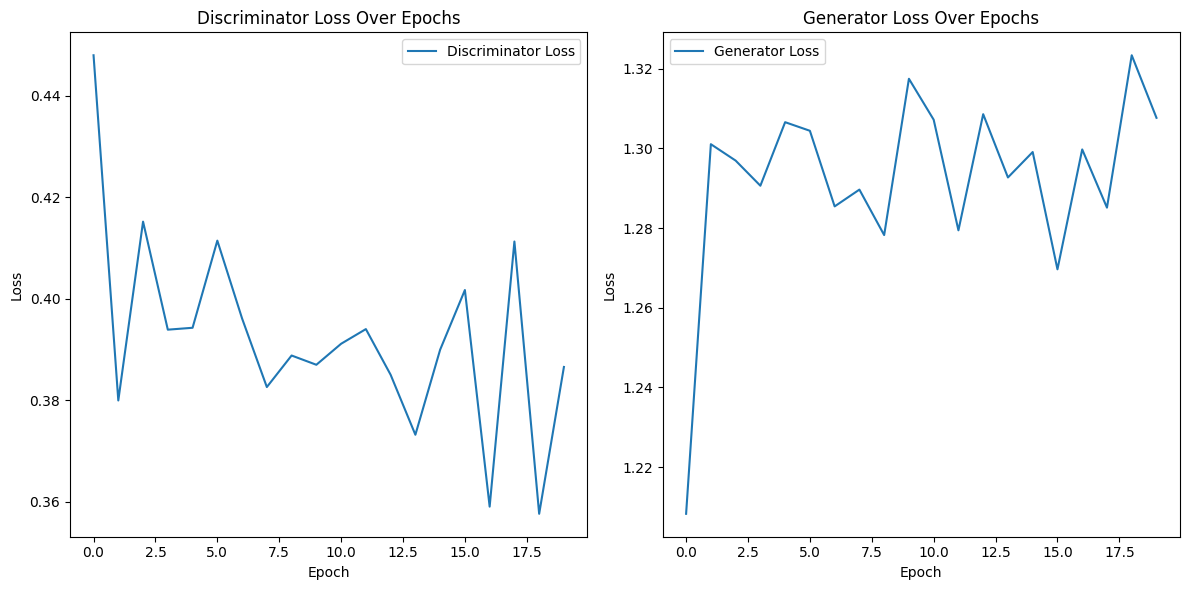

In [ ]:
# Plotting the losses
plt.figure(figsize=(12, 6))

# Plot Discriminator Loss
plt.subplot(1, 2, 1)
plt.plot(loss_desc_history, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss Over Epochs')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 2, 2)
plt.plot(loss_gan_history, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

After training:


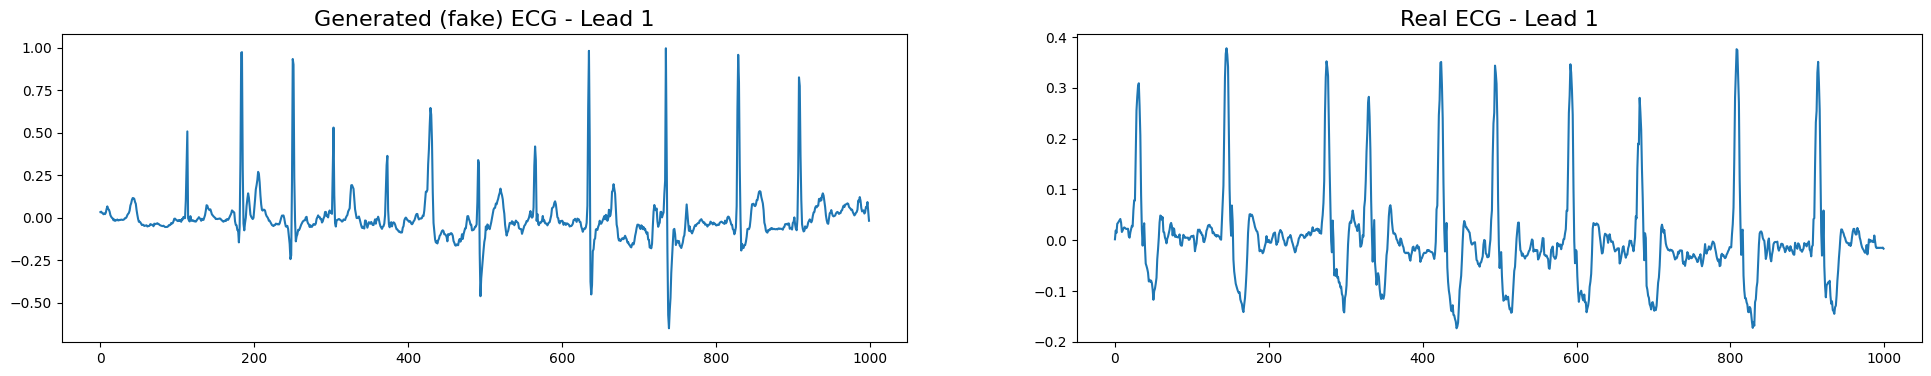

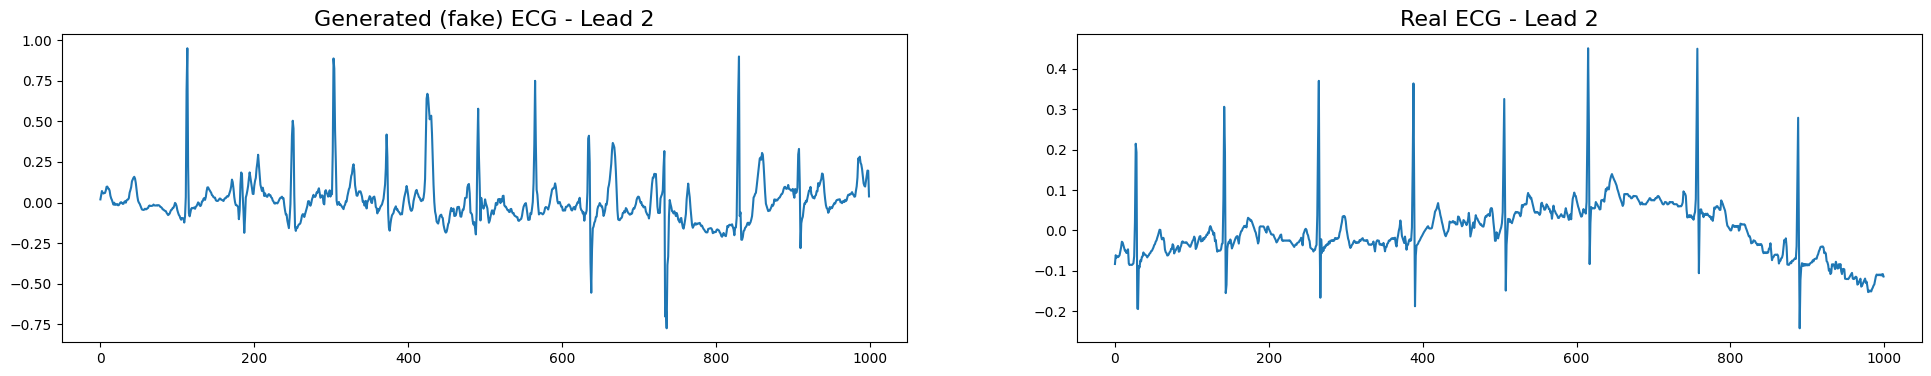

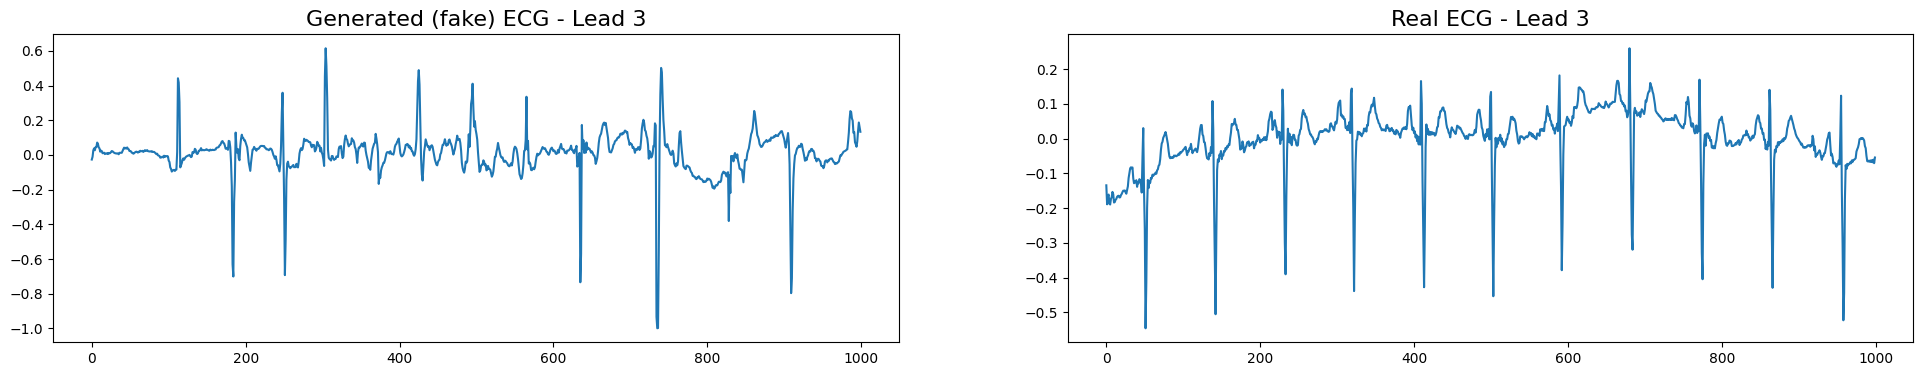

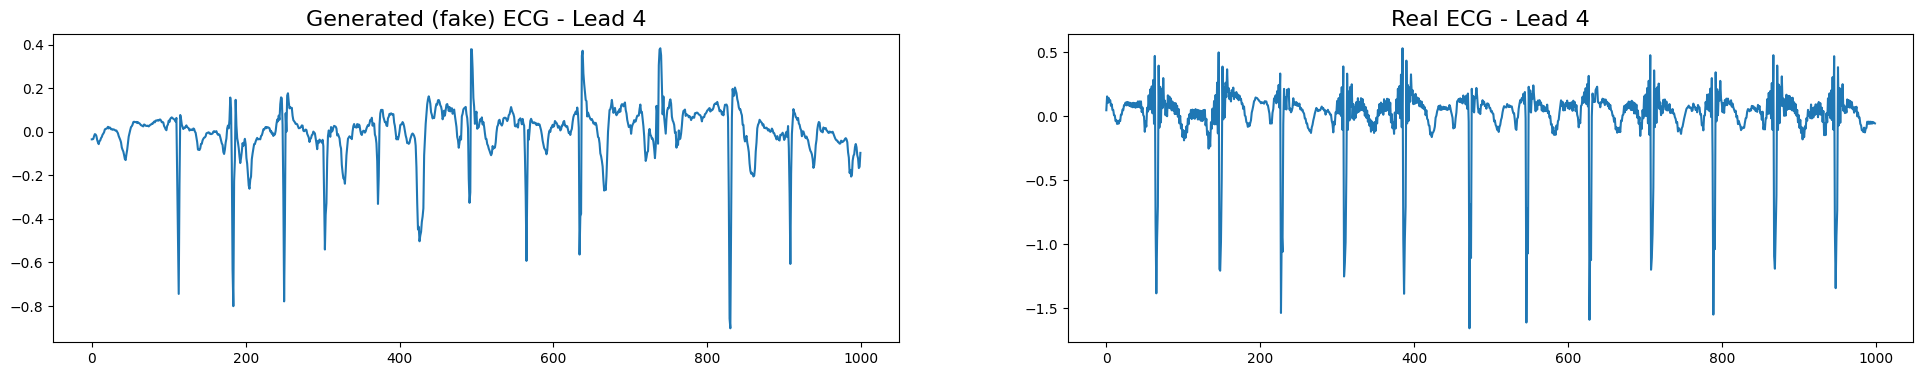

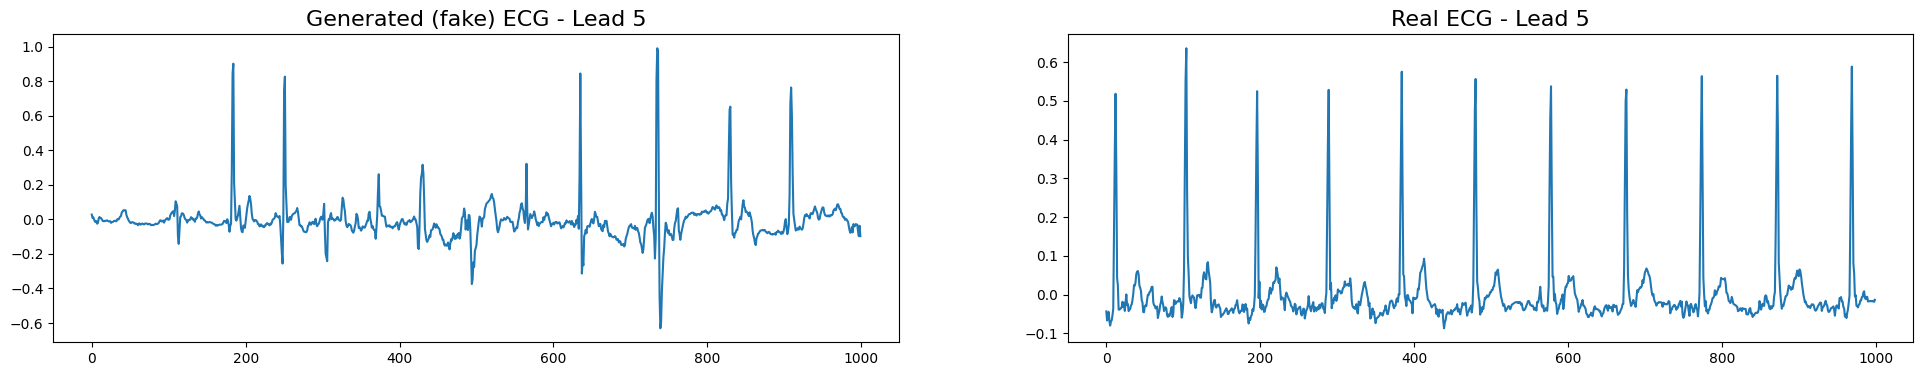

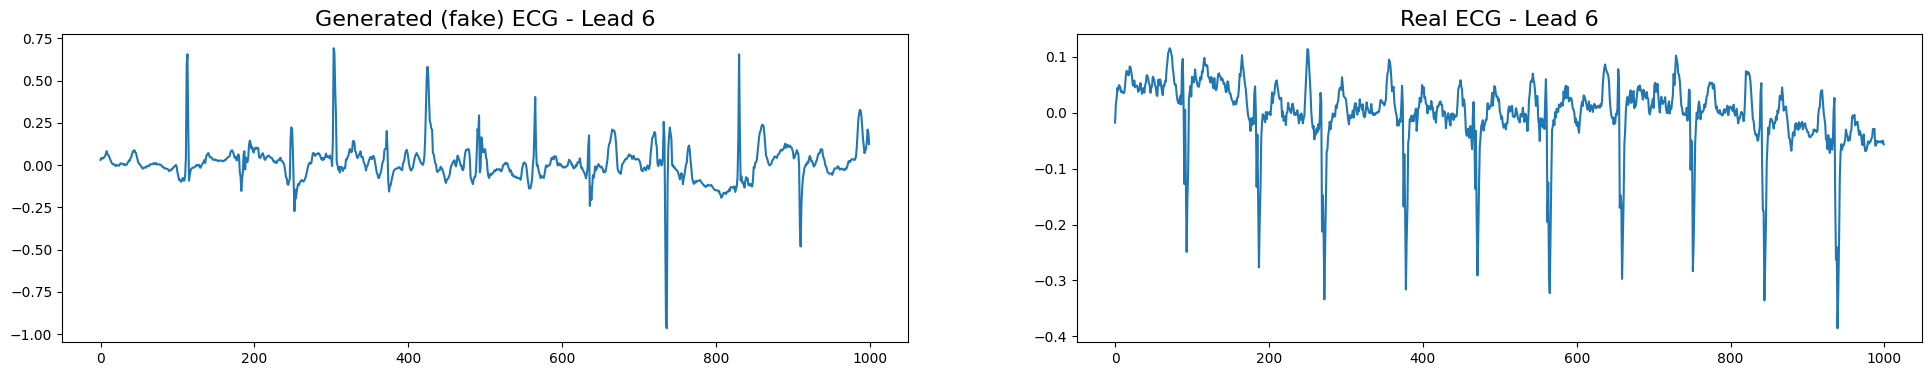

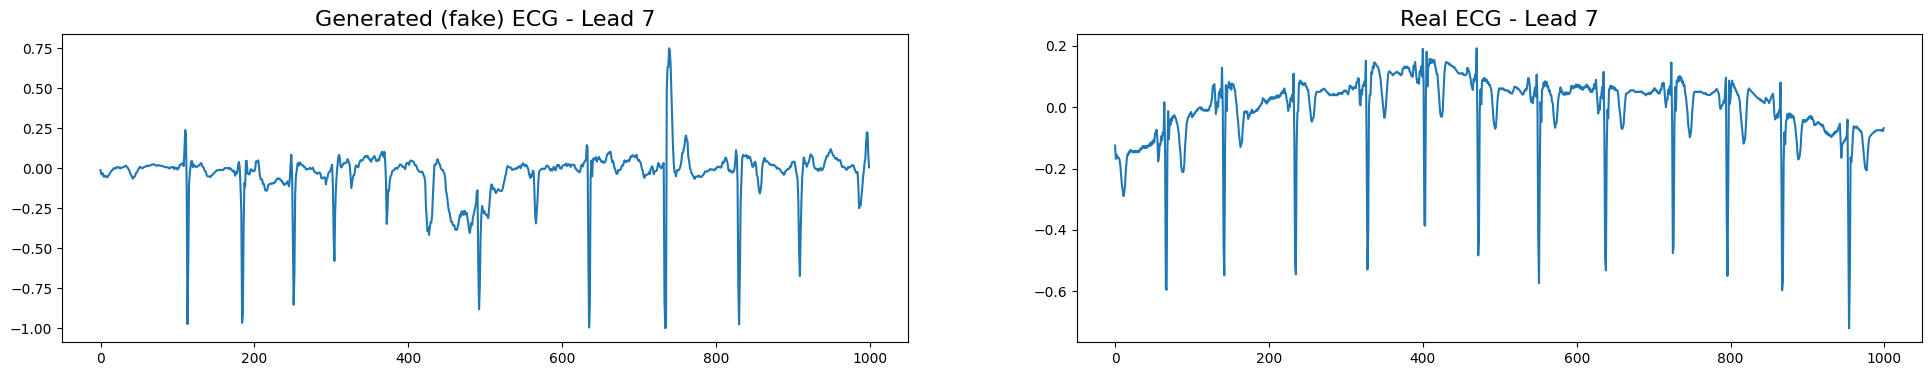

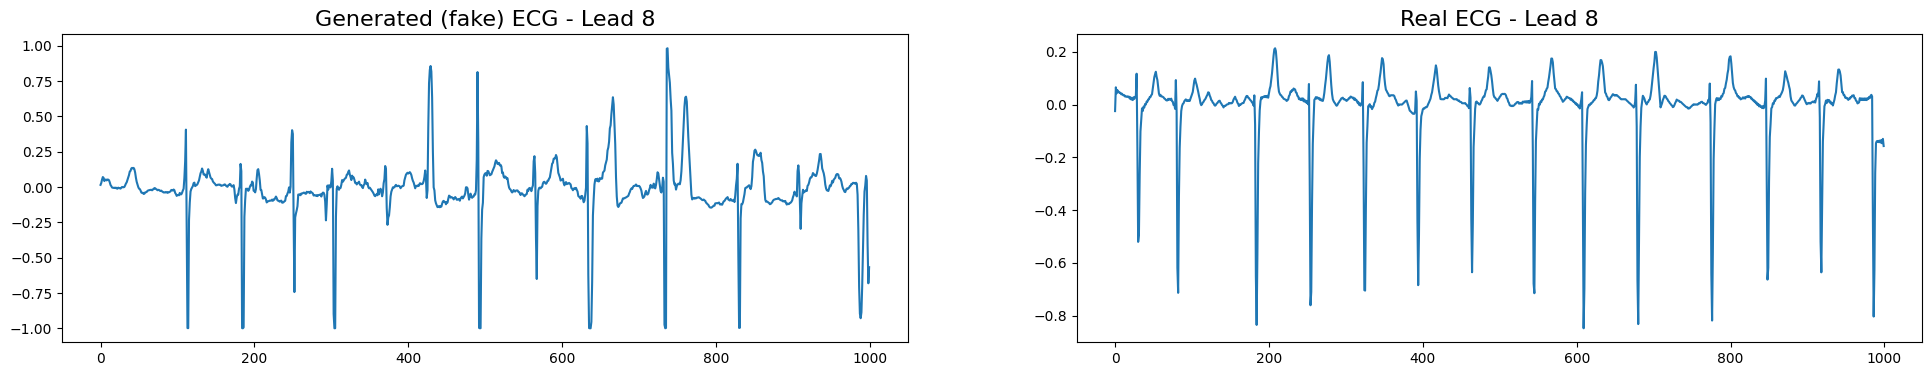

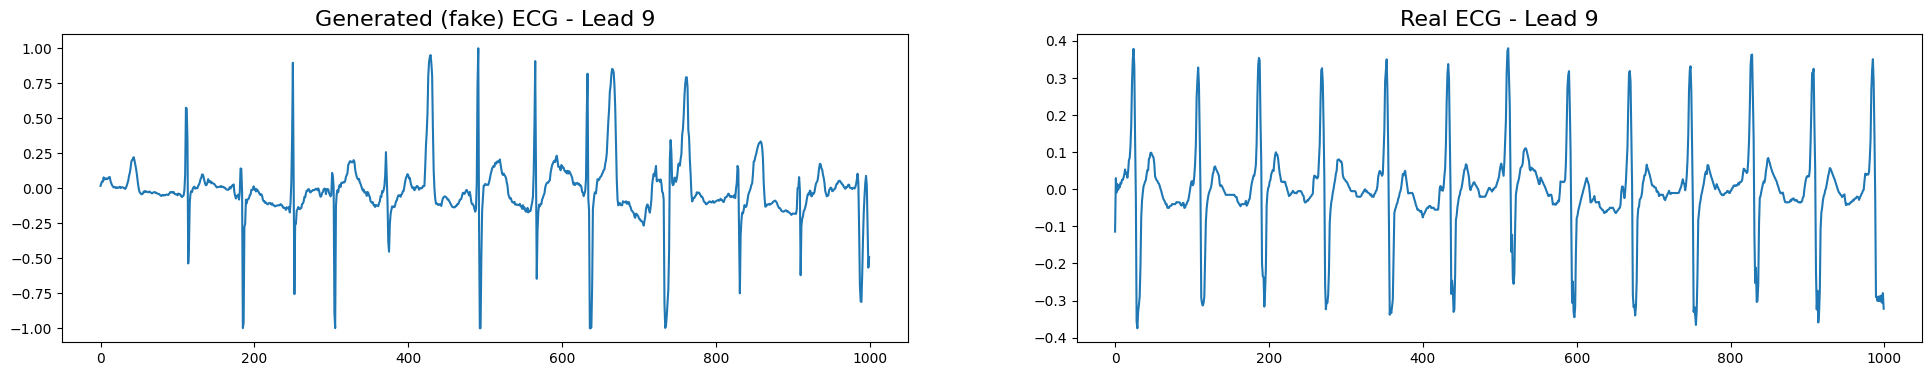

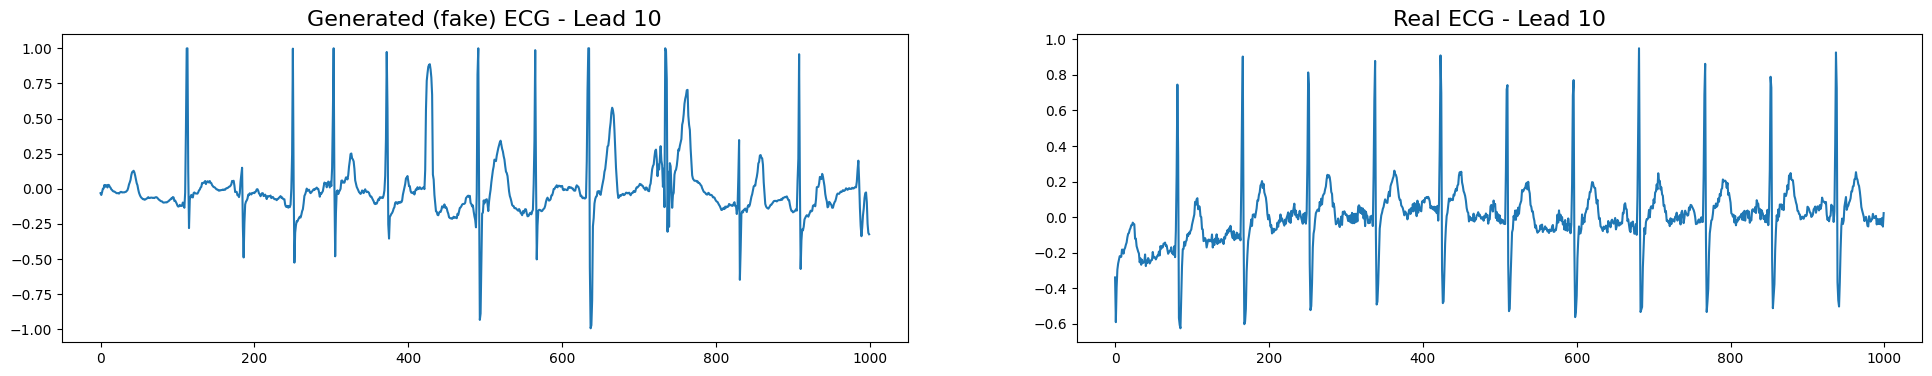

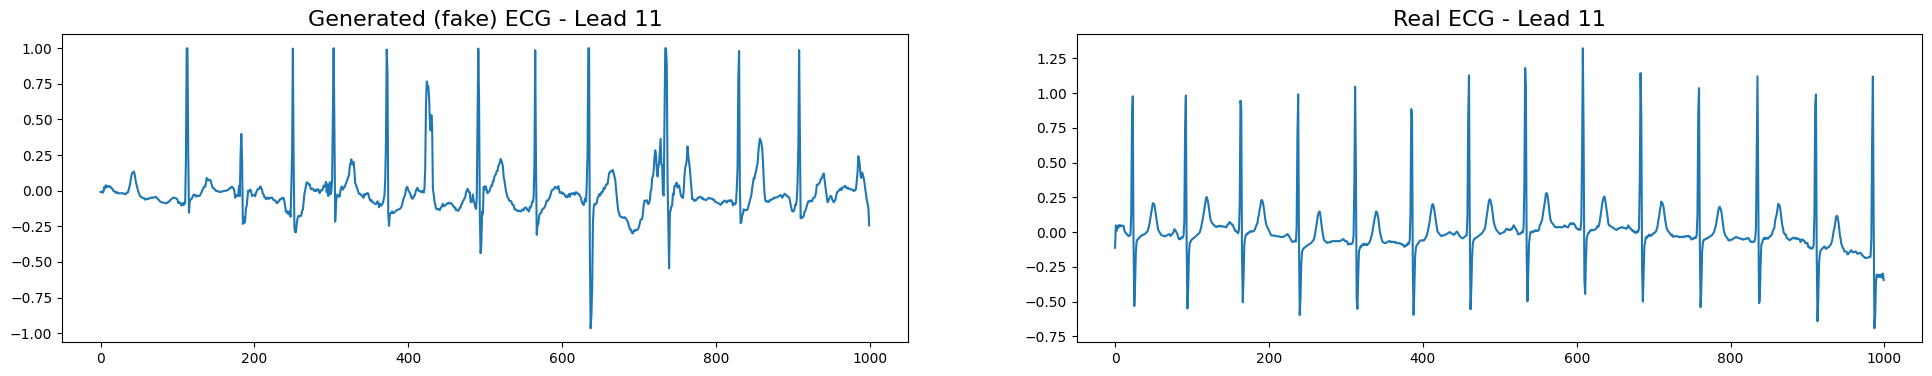

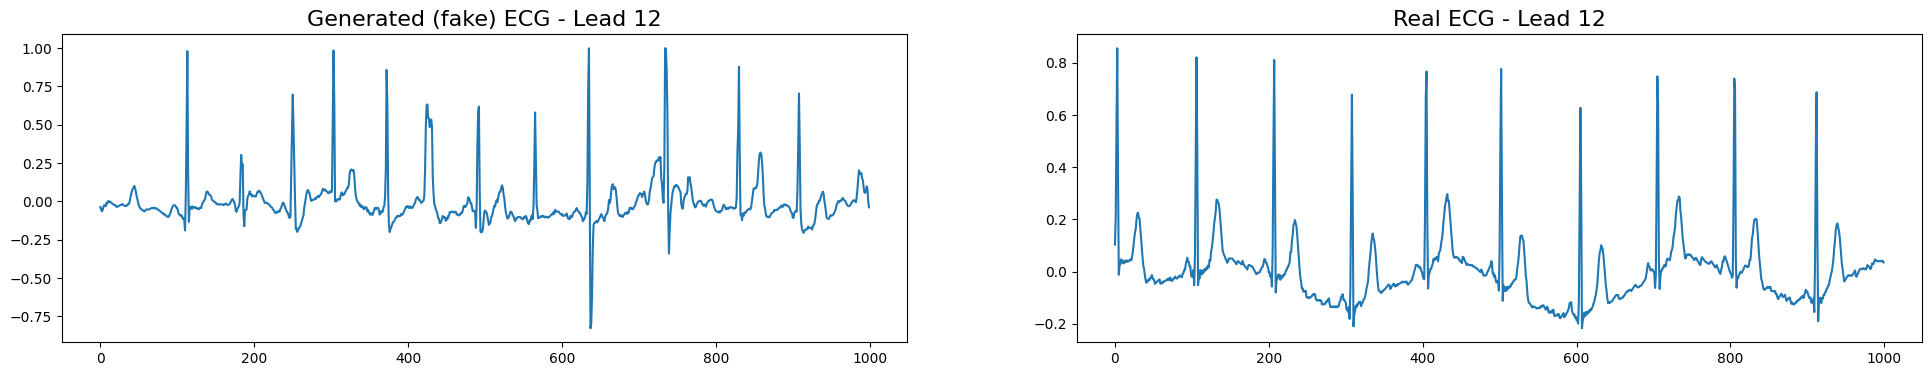

-------------------


In [ ]:
print("After training:")
res = generator(generate_latent_points(latent_dim, 1))
for lead in range(0,12):
    compare_real_and_gen_ecg(res,lead)
print("-------------------")


In [ ]:
generator.save_weights("generator_weights_RMSprop.weights.h5")
discriminator.save_weights("descriminator_RMSprop_round3.weights.h5")